## A demo using two-qubit HeisenbergModel Hamiltonian with GPT-QE (using minGPT code).

In [22]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [23]:
from qwrapper.hamiltonian import HeisenbergModel
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.initializer import ZBasisInitializer
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer

molecule = generate_molecule("H", "H", 0.7414, "sto-3g")
nqubit = 4

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule)

# prepare operator_pool
uccsd = UCCSD(4, molecule)
paulis = uccsd.paulis
print('paulis', paulis)
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool,
                  [0.00625, -0.00625, 0.0125, -0.0125, 0.025, -0.025, 0.05, -0.05, 0.1, -0.1])


converged SCF energy = -1.11668438708534
Starting to parse FermionOperator using 4 qubits...

Operator t:  -0.09886396933545816 [] +
0.04532220205287399 [X0 Z1 X2] +
0.04532220205287399 [X0 Z1 X2 Z3] +
0.04532220205287399 [Y0 Z1 Y2] +
0.04532220205287399 [Y0 Z1 Y2 Z3] +
0.17119774903432977 [Z0] +
0.17119774903432972 [Z0 Z1] +
0.165867024105892 [Z0 Z1 Z2] +
0.165867024105892 [Z0 Z1 Z2 Z3] +
0.12054482205301804 [Z0 Z2] +
0.12054482205301804 [Z0 Z2 Z3] +
0.1686221915892094 [Z1] +
-0.2227859304041847 [Z1 Z2 Z3] +
0.17434844185575682 [Z1 Z3] +
-0.22278593040418473 [Z2]
Term, coeff:  () -0.09886396933545816
Term, coeff:  ((0, 'Z'),) 0.17119774903432977
Index, p_char:  0 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.17119774903432972
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.22278593040418473
Index, p_char:  2 Z
Term, coeff:  ((1, 'Z'), (2, 'Z'), (3, 'Z')) -0.2227859304041847
Index, p_char:  1 Z
Index, p_char:  2 Z
Index, p_char:  3 Z
Term, coeff:  ((1, 'Z'),) 0.1686221915

## FCI energy by diagonalization

In [24]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))

-1.137270174660903


## Setup for GPT

In [25]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2-medium'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 30  # The number of gates for each circuit
model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
model_config.embd_pdrop = 0
model_config.resid_pdrop = 0
model_config.attn_pdrop = 0
model = GPT(model_config, cost)

number of parameters: 302.54M


In [26]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 300
train_config.num_workers = 0
train_config.n_samples = 5
trainer = Trainer(train_config, model)

running on device cpu


In [27]:
def batch_end_callback(trainer):
    if trainer.iter_num % 1 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        model.temperature += 0.01


trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_test')

energies: tensor([-0.1220, -0.0923, -0.1517, -0.1321, -0.2319])
mean: tensor(-0.1460)
iter_dt 0.00ms; iter 0: train loss 1.69172
energies: tensor([-0.1679, -0.2601, -0.2088, -0.2191, -0.1901])
mean: tensor(-0.2092)
iter_dt 1694576748824.54ms; iter 1: train loss 0.68812
energies: tensor([-0.2116, -0.3195, -0.3535, -0.2082, -0.2873])
mean: tensor(-0.2760)
iter_dt 45069.07ms; iter 2: train loss 0.42764
energies: tensor([-0.1941, -0.1827, -0.3721, -0.2234, -0.3965])
mean: tensor(-0.2738)
iter_dt 45108.16ms; iter 3: train loss 0.27777
energies: tensor([-0.2456, -0.3132, -0.3956, -0.1442, -0.1516])
mean: tensor(-0.2500)
iter_dt 45262.23ms; iter 4: train loss 0.22467
energies: tensor([-0.3647, -0.1519, -0.0999, -0.1828, -0.3539])
mean: tensor(-0.2306)
iter_dt 45269.52ms; iter 5: train loss 0.18081
energies: tensor([-0.1601, -0.2366, -0.1969, -0.2726, -0.2036])
mean: tensor(-0.2140)
iter_dt 45214.74ms; iter 6: train loss 0.16212
energies: tensor([-0.4027, -0.2907, -0.2220, -0.4253, -0.1039])
m

In [28]:
model.load_state_dict(torch.load('../saved_models/gptqe_test'))

<All keys matched successfully>

tensor([[104, 104, 104,  68, 104, 104, 104,  51,  51,  68,  51, 104,  68, 104,
         104, 104,  51,  51, 104, 104,  68, 104,  51,  68,  51, 104, 104, 104,
          68, 104]])


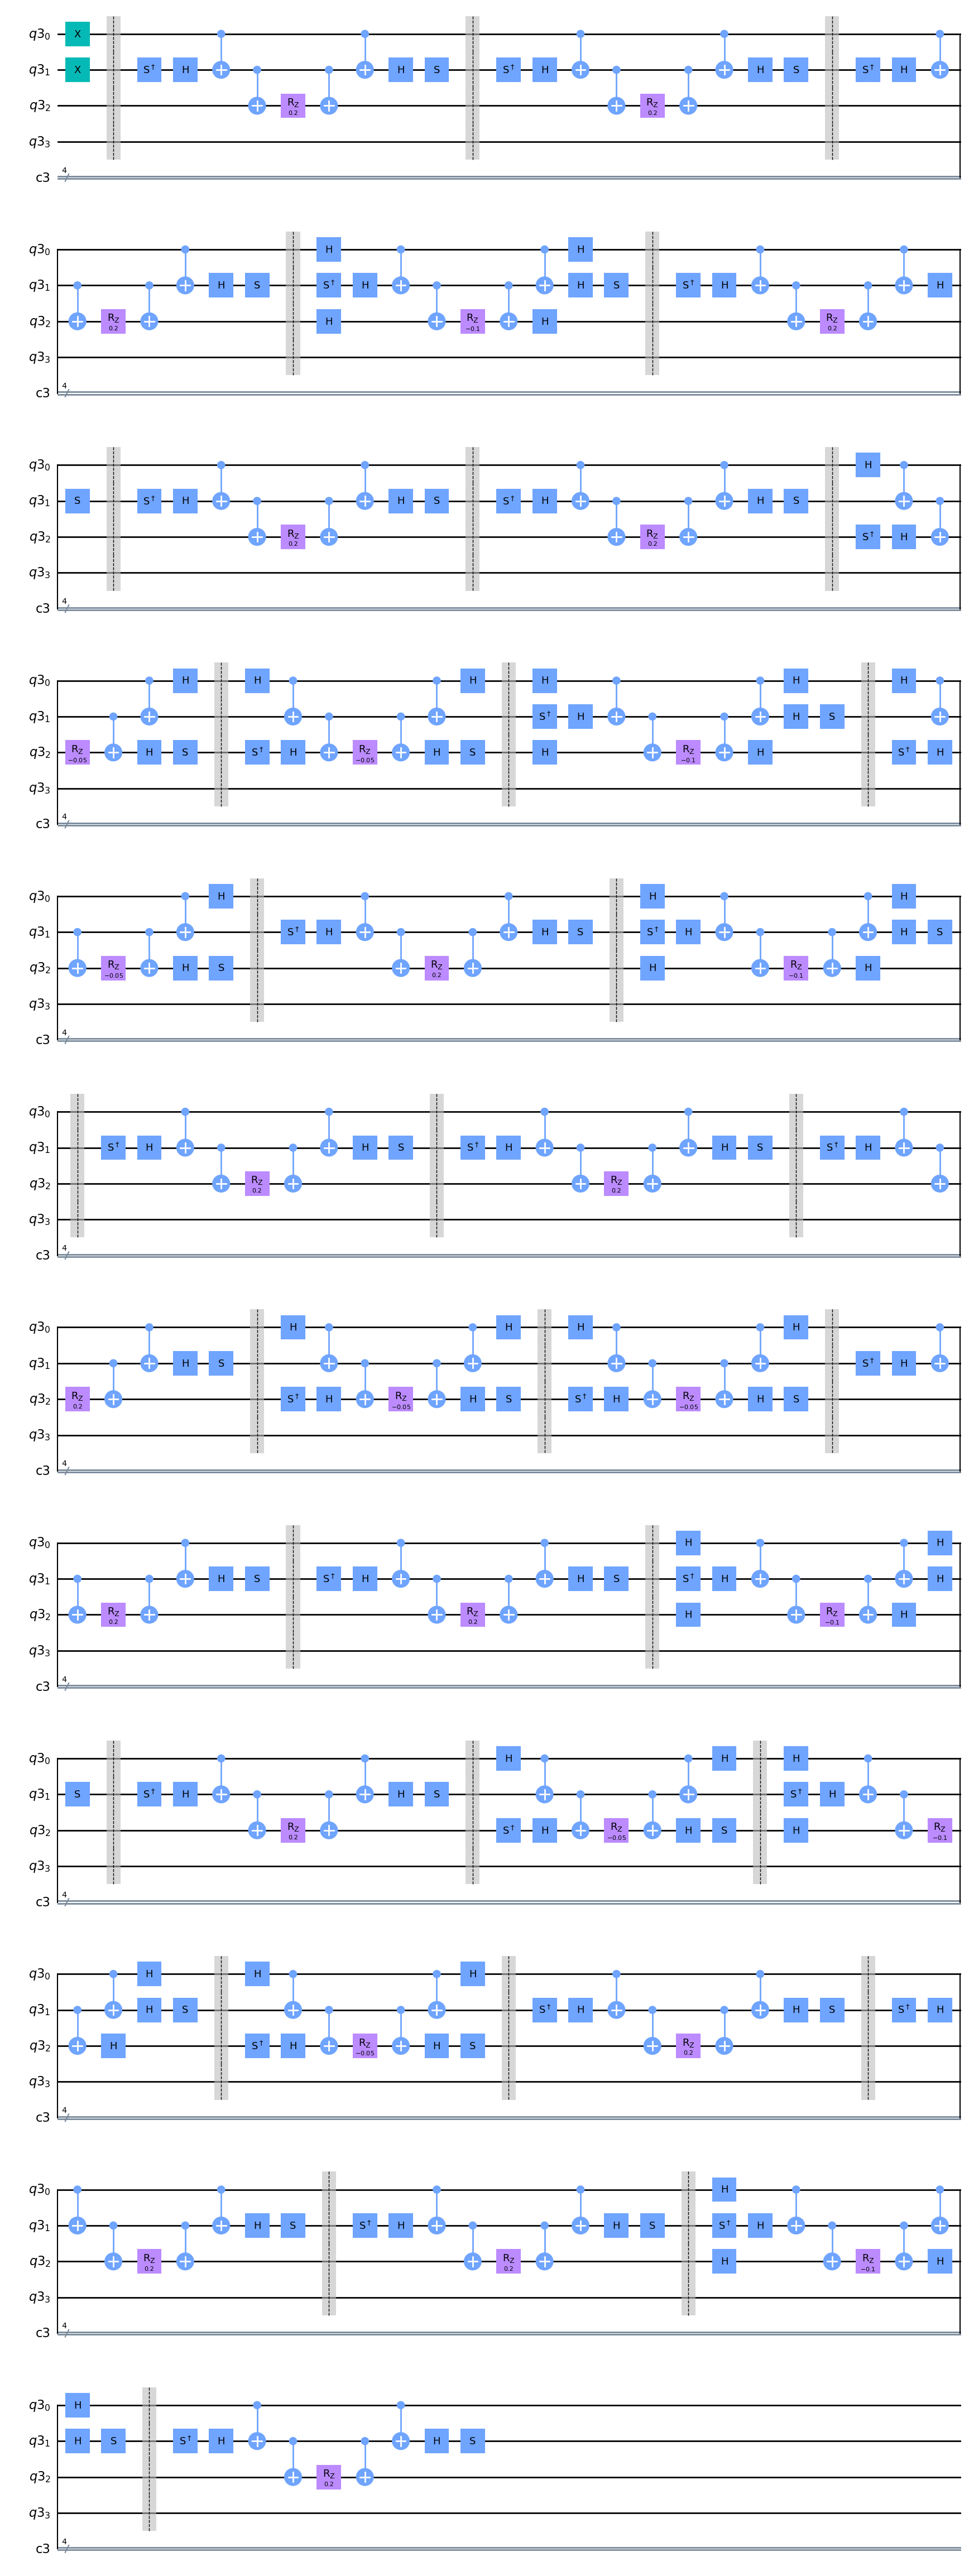

In [29]:
indices, logits = model.generate(torch.tensor([[0]]), model_config.n_gates)
cost.sequence.tool = "qiskit"
print(indices)
cost.sequence._get_circuit(indices.numpy()[0]).qc.draw(output="mpl", plot_barriers=True)